In [3]:
import pandas as pd
import numpy as np
import csv
import os
from os import path
import weblogo
import seqlogo
%matplotlib inline

In [8]:
filteredGeneList = pd.read_csv('../Database/filteredGenesDetails_human_240118.txt',sep='\t')
acc2gene={}
gene2acc={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']
    gene2acc[row['GeneName']] = row['AccNum']

In [9]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [10]:
splicedGenes = get_fa('../Database/splicedGenes_240118.txt')
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
splicedORFs = get_fa('../Database/splicedORFs_240118.txt')

In [11]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

In [12]:
class Sequences:
    
    @staticmethod
    def genes2seq(genes):
        seqs = []
        for gene in genes:
            fp=fpUTR[gene]
            if len(fp)<40:
                #print('No fpUTR encountered: ',acc2gene[gene])
                continue
            seq = fp[-35:-19] #position -35 to position -20
            seqs.append(seq)
        print('# of valid seqs: ',len(seqs))
        return seqs
    
    def __init__(self,seqs):
        self.seqs=seqs
        self.pfm, self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def addseqs(self,seqs):
        self.seqs.extend(seqs)
        self.pfm,self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def __len__(self):
        return len(self.seqs)
    
    def comp_count(self,seqLen=16):
        
        raw_count = np.zeros((seqLen,4))
        lines_tr=[''.join(s) for s in zip(*(self.seqs))]
        #print('#lines = ',len(seqs))
        for i in range(seqLen):
            raw_count[i][0] = lines_tr[i].count('A')
            raw_count[i][1] = lines_tr[i].count('C')
            raw_count[i][2] = lines_tr[i].count('G')
            raw_count[i][3] = lines_tr[i].count('T')
        ppm = self.pfm2ppm(raw_count)
        return raw_count, ppm
    
    ## Note: ppm here is the same as the so-called pwm in R,
    ## True meaning of 'pwm' vary from literatures
    def pfm2ppm(self,pfm):
        sum_of_rows = pfm.sum(axis=1)
        return pfm / sum_of_rows[:, np.newaxis]
    
    def plotlogo(self):
        pfm_pd=pd.DataFrame(self.pfm)
        ppm_pd=seqlogo.pfm2ppm(pfm_pd)
        ppm = seqlogo.Ppm(ppm_pd)
        plt=seqlogo.seqlogo(ppm, ic_scale = True, format = 'png', size = 'large')#,filename=datset+'.png')
        #seqlogo.seqlogo(ppm, ic_scale = True, format = 'svg', size = 'medium')#,filename=datset+'.svg')
        return plt
    
    def ppm2flat(self):
        return self.ppm.reshape(-1)
    
    
    def bootstrap(self,num):    # with replacement
        sample_seqs = np.random.choice(self.seqs, size=num)
        return Sequences(sample_seqs.tolist())
    
    def sample(self,num): # without replacement
        sample_seqs = np.random.choice(self.seqs, size=num,replace=False)
        return Sequences(sample_seqs.tolist())

    def __gt__(self, seq2):
        return True

In [26]:
fil = 8
name = 'fil'+str(fil)+'_cluster_mergeRPKM'
df = pd.read_csv(name)
df.head()

,Unnamed: 0,id,k_means_8,T0_TE,T1_TE,T2_TE,RNA_0,RNA_1,RNA_2,totalRPF_0,totalRPF_1,totalRPF_2
0,6,NM_000027,1,0.63,0.73,0.48,15.779673,9.853032,11.982563,46.979570,33.656786,29.065811
1,17,NM_000097,1,0.21,1.00,0.16,28.458655,90.727115,379.128313,62.544405,363.153345,742.768500
2,22,NM_000108,1,1.23,1.60,0.93,31.595398,45.824872,24.910036,140.722476,279.857036,82.512417
3,23,NM_000110,1,-0.12,0.14,-0.40,12.743533,3.634789,2.724057,22.396782,8.076889,3.573496
4,25,NM_000113,1,0.43,0.67,0.39,26.830445,13.692785,13.217789,68.783423,43.303580,30.326759


In [27]:
for i in range(1,9):
    ids = list(df.loc[df['k_means_8'] == i, 'id'])
    seq = Sequences(Sequences.genes2seq(ids))
    img=seq.plotlogo()
    with open("fil"+str(fil)+"/cluster "+str(i)+".png", "wb") as png:
        png.write(img.data)

# of valid seqs:  974
# of valid seqs:  783
# of valid seqs:  1000
# of valid seqs:  807
# of valid seqs:  1021
# of valid seqs:  1106
# of valid seqs:  989
# of valid seqs:  1083


# of valid seqs:  1143


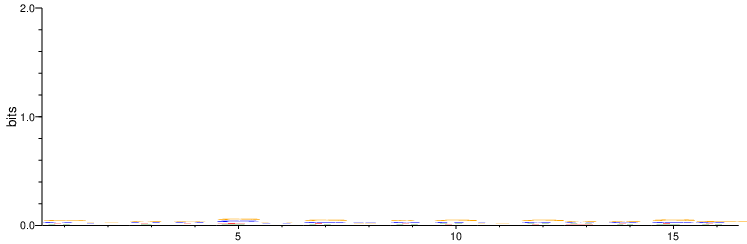